# Rollout model per country

## Compute Grids for inference

### load per country admin boundaries

In [1]:
import geopandas as gpd
from pathlib import Path

In [2]:
admin_file = 'region34ncr_admin.geojson'

In [3]:
data_dir = Path('../neowrangler_data')

In [4]:
admin_path = data_dir/admin_file

In [5]:
%%time
admin_gdf = gpd.read_file(admin_path)

CPU times: user 4.96 s, sys: 409 ms, total: 5.37 s
Wall time: 5.34 s


In [6]:
admin_gdf.describe()

/home/butchtm/work/povmap/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/home/butchtm/work/povmap/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:387: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/butchtm/work/povmap/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:388: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get 

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
count,3,3,3,3
unique,3,3,3,3
top,130000000,National Capital Region,NCR,"(POLYGON ((121.0384166 14.7852471, 121.0381529..."
freq,1,1,1,1


In [7]:
admin_gdf.head()

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,130000000,National Capital Region,NCR,"MULTIPOLYGON (((121.03842 14.78525, 121.03815 ..."
1,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."
2,040000000,Region IV-A,Calabarzon,"MULTIPOLYGON (((122.72165 13.36485, 122.72143 ..."


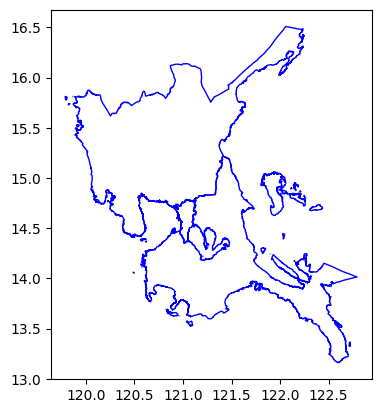

In [8]:
ax = admin_gdf.plot(facecolor='none',edgecolor='blue')

### generate grid for all admin areas

In [9]:
from geowrangler import grids

In [10]:
grid_gen = grids.SquareGridGenerator(4_000) # 4km grids

In [11]:
%%time
admin_grids = grid_gen.generate_grid(admin_gdf)

CPU times: user 4.9 s, sys: 58.6 ms, total: 4.96 s
Wall time: 4.96 s


In [12]:
from geowrangler import spatialjoin_highest_intersection as sjhi 

In [13]:
admin_grids.describe()

,x,y
count,3042.000000,3042.000000
mean,38.498356,47.770217
std,18.768747,21.811171
min,0.000000,0.000000
25%,25.000000,28.000000
50%,37.000000,49.000000
75%,50.000000,66.000000
max,83.000000,96.000000


In [14]:
admin_grids.columns.values

array(['x', 'y', 'geometry'], dtype=object)

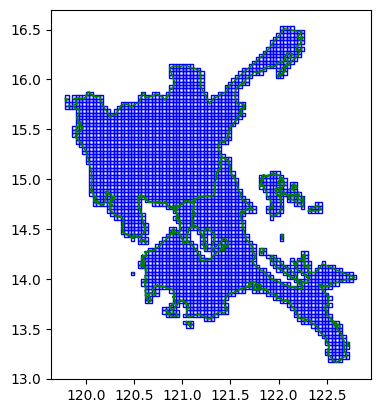

In [15]:
ax = admin_grids.plot(facecolor='none',edgecolor='blue')
ax = admin_gdf.plot(ax=ax,facecolor='none',edgecolor='green')

### load human pop layer

In [16]:
human_pop_file = 'phl_ppp_2020_constrained.tif' 

In [17]:
human_pop_path = data_dir/human_pop_file

In [18]:
import rasterio as rio

In [19]:
with rio.open(human_pop_path.as_posix()) as src:
    data = src.read(1)
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 11613, 'height': 19781, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333299750276, 0.0, 116.927916214,
       0.0, -0.0008333333300136493, 21.070416784), 'blockysize': 1, 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


### compute pop per grid

In [20]:
import matplotlib.pyplot as plt

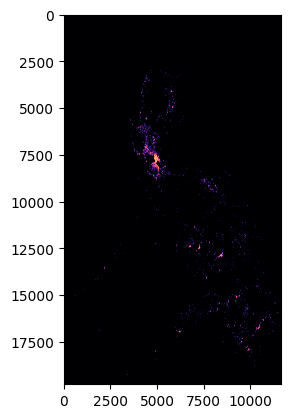

In [21]:
ax = plt.imshow(data, cmap='magma')

In [22]:
from geowrangler import raster_zonal_stats as rzs

In [23]:
%%time
admin_grids = rzs.create_raster_zonal_stats(admin_grids, human_pop_path.as_posix(),
                                            aggregation=dict(func='sum',output='total_pop',fillna=True),
                                            extra_args=dict(nodata=-99999))

CPU times: user 27 s, sys: 896 ms, total: 27.9 s
Wall time: 27.9 s


### filter grids out pop == 0

In [24]:
len(admin_grids)

3042

In [25]:
admin_grids.describe()

,x,y,total_pop
count,3042.000000,3042.000000,3042.000000
mean,38.498356,47.770217,12953.974312
std,18.768747,21.811171,44837.590474
min,0.000000,0.000000,0.000000
25%,25.000000,28.000000,0.000000
50%,37.000000,49.000000,1084.438232
75%,50.000000,66.000000,8634.516602
max,83.000000,96.000000,599703.625000


In [26]:
pop_admin_grids = admin_grids[admin_grids.total_pop > 0]; len(pop_admin_grids)

2029

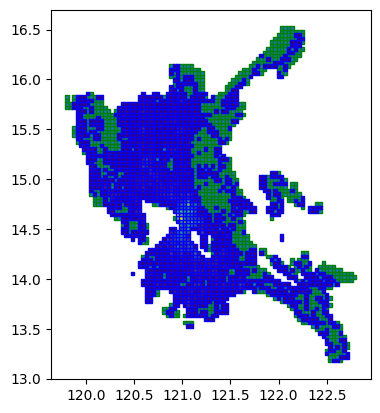

In [27]:
ax = admin_grids[admin_grids.total_pop == 0].plot(edgecolor='green')
ax = pop_admin_grids.plot(column='total_pop', edgecolor='blue', ax=ax)

In [28]:
# %%time
pop_admin_grids = sjhi.get_highest_intersection(pop_admin_grids,admin_gdf, pop_admin_grids.crs)

/home/butchtm/work/povmap/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geowrangler/spatialjoin_highest_intersection.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlay.geometry.area


In [29]:
pop_admin_grids.columns.values

array(['geometry', 'x', 'y', 'total_pop', 'Reg_Code', 'Reg_Name',
       'Reg_Alt_Name'], dtype=object)

In [30]:
pop_admin_grids.head()

,geometry,x,y,total_pop,Reg_Code,Reg_Name,Reg_Alt_Name
0,"POLYGON ((120.46855 14.03509, 120.50449 14.035...",19,25,33.217255,040000000,Region IV-A,Calabarzon
1,"POLYGON ((120.57635 14.10480, 120.61228 14.104...",22,27,4401.518555,040000000,Region IV-A,Calabarzon
2,"POLYGON ((120.54042 14.10480, 120.57635 14.104...",21,27,729.269165,040000000,Region IV-A,Calabarzon
3,"POLYGON ((120.54042 14.13965, 120.57635 14.139...",21,28,71.550423,040000000,Region IV-A,Calabarzon
4,"POLYGON ((120.57635 14.17449, 120.61228 14.174...",22,29,812.476868,040000000,Region IV-A,Calabarzon


In [31]:
pop_admin_grids.describe()

,x,y,total_pop
count,2029.000000,2029.000000,2029.000000
mean,35.295219,45.929029,19421.384848
std,16.856720,20.215552,53748.999509
min,2.000000,0.000000,1.879009
25%,23.000000,27.000000,1082.331787
50%,33.000000,47.000000,5045.576172
75%,45.000000,63.000000,13759.560547
max,81.000000,94.000000,599703.625000


## Run Inference

### Load model

### Compute predicted wealth index for all grids